In [1]:
#!/usr/bin/python
# updated DBR 02/2025 #

%matplotlib inline

import numpy as np
import scipy.optimize as opt
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [2]:
#names, paaired

PWH_ppts = ['PWH22','PWH548','PWH746','PWH583','PWH1211']
ctl_ppts = ['MACS10136','MACS13042','MACS14173','WIHS','MACS14218']


In [4]:
#read output dataframe from make_dfs-TCR
outdf=pd.read_csv('data/clean/ecometrics_wprovirusrecalc.csv')

#read HIV clone data
df1=pd.read_csv('data/clean/PWHproviral.csv')
df2=pd.read_csv('data/clean/DELSPCprovirus-dbr.csv')

DELcolor='tab:purple'


In [6]:
#list but leave off 1 that doesn't have TCR
pids = list(outdf['pid'])
#pids.remove('DELSPC26')

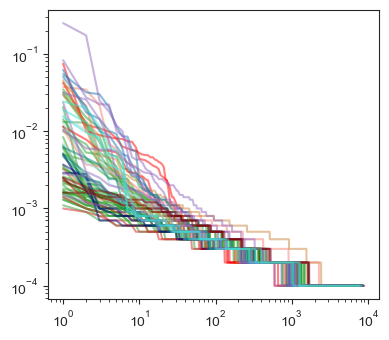

In [8]:
#plot all rank abundances on one plot, not restricted

#now resample to a realistic size in a new df
sample_size = 10000

plt.figure(figsize=(4,3.5))
for i,pid in enumerate(pids):
    #pid=fn.split('.')[0]
        
    df0 = pd.read_csv('data/clean/TCR/'+pid+'.csv')

    #now make resampled dataframes
    pa = df0['templates']/np.sum(df0['templates'])
    rs = np.random.multinomial(n=sample_size,pvals=pa)

    #calculate ecology and add to lists
    TCR=rs[rs>0]
    N=np.sum(df0['templates']);
    R=len(TCR);  
    r=np.arange(R)+1
    a=-np.sort(-TCR)
    pars=a/np.sum(a)
    plt.loglog(r,pars,ls='-',color=outdf['color'].iloc[i],alpha=0.5)

plt.tight_layout()
plt.savefig('figures/SADs-allTCR.svg',dpi=600)


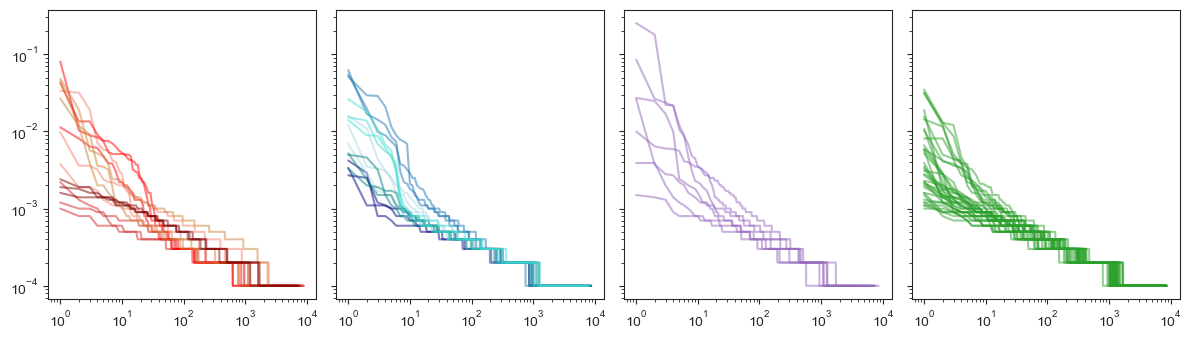

In [20]:
#plot all rank abundances by cohort

#now resample to a realistic size in a new df
sample_size = 10000

fig,axs=plt.subplots(1,4,figsize=(12,3.5),sharex=True,sharey=True)
for i,pid in enumerate(pids):
    #pid=fn.split('.')[0]
        
    df0 = pd.read_csv('data/clean/TCR/'+pid+'.csv')

    axi = outdf['cohort_num'].iloc[i]-1
        
    #now make resampled dataframes
    pa = df0['templates']/np.sum(df0['templates'])
    rs = np.random.multinomial(n=sample_size,pvals=pa)

    #calculate ecology and add to lists
    TCR=rs[rs>0]
    N=np.sum(df0['templates']);
    R=len(TCR);  
    r=np.arange(R)+1
    a=-np.sort(-TCR)
    pars=a/np.sum(a)
    
    axs[axi].loglog(r,pars,ls='-',color=outdf['color'].iloc[i],alpha=0.5)

plt.tight_layout()
plt.savefig('figures/SADs-bycohort.svg',dpi=600)


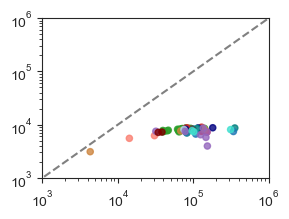

In [21]:
#unrestricted, just to look at sample sizes

plt.figure(figsize=(3,2.3))
plt.scatter(outdf['initial_N'],outdf['R'],s=20,alpha=0.8,c=outdf['color'])
plt.loglog([1,1e6],[1,1e6],ls='--',color='gray')
plt.xlim([1e3,1e6])
plt.ylim([1e3,1e6])
#plt.xlabel('Sample size')
#plt.ylabel('Observed richness')
plt.tight_layout()
plt.savefig('figures/TCRrarefaction.svg',dpi=600)


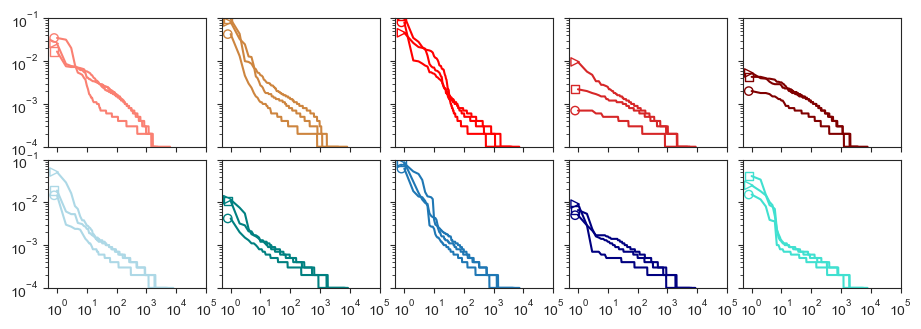

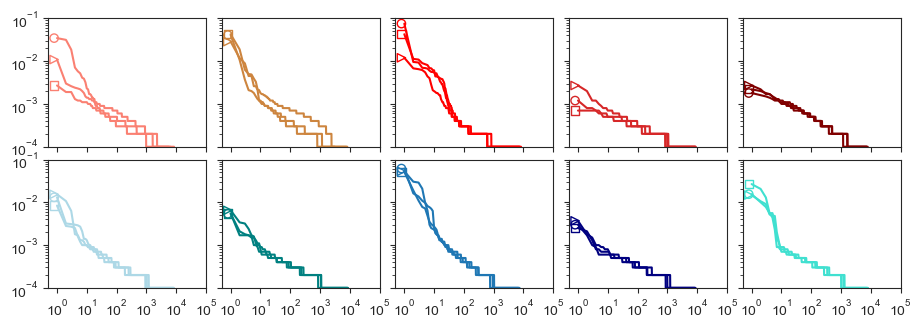

In [25]:
#show all longitudinal SADs
#loop over persistents vs not

sample_size=10000
mz=['o','s','>']

for only_persistent in [True, False]:
    fig,axarr=plt.subplots(2,5,sharex=True,sharey=True,figsize=(11,3.5))
    for ip,pid in enumerate(PWH_ppts+ctl_ppts):

        cz=outdf['color'][outdf['pid']==pid+'_t0'].iloc[0] #get the color for this ppt
        ax=axarr[int(ip/5)][np.mod(ip,5)]
        for tp in range(3):
            if only_persistent:
                df0=pd.read_csv('data/clean/TCR/restricted/'+pid+'_t'+str(tp)+'.csv') #read TCR data for that ppt
            else:
                df0=pd.read_csv('data/clean/TCR/'+pid+'_t'+str(tp)+'.csv') #read TCR data for that ppt

            p_a=-np.sort(-df0['templates'])/np.sum(df0['templates'])
            rs = np.random.multinomial(n=sample_size,pvals=p_a)

            #calculate ecology and add to lists
            TCR=rs[rs>0]
            r=np.arange(len(TCR))+1
            a=-np.sort(-TCR)
            pars=a/np.sum(a)

            ax.loglog(r,pars,color=cz)#,lw=tp+1)
            ax.scatter(0.8,pars[0],marker=mz[tp],label=tp,facecolors='none', edgecolors=cz)#lw=tp+1)
        #ax.annotate(str(ip),[100,5e-2],fontsize=10)
        #ax.set_title(pid)

    ax.set_xticks(np.logspace(0,5,6))
    ax.set_yticks(np.logspace(-5,-1,5))
    ax.set_ylim([1e-4,1e-1])     

    fig.subplots_adjust(hspace = 0.1, wspace=0.1)
    fig.savefig('figures/SADS-longitudinal-persist='+str(only_persistent)+'.svg',dpi=600)



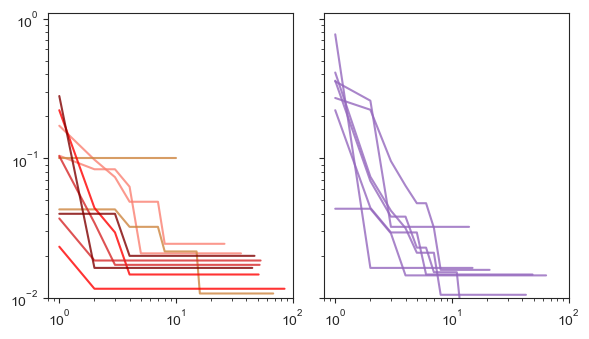

In [34]:
#plot all HIV clone rank abundances

fig,axs=plt.subplots(1,2,figsize=(6,3.5),sharex=True,sharey=True)

HIVss=60

PWH_ppts2 = ['22','548','746','583','1211'] #not formatted with PWH

for ip,pid in enumerate(PWH_ppts2):

    cz=outdf['color'][outdf['pid']=='PWH'+pid+'_t0'].iloc[0] #get the color for this ppt
    tdf=df1[df1['pid']==int(pid)]
    
    for it,tt in enumerate(tdf['monthsART'].unique()):
        tdf2 = tdf[tdf['monthsART']==tt]
        
        a=-np.sort(-tdf2['counts'])
        a=a[a>0]
        axs[0].loglog(np.arange(len(a))+1,a/np.sum(a),color=cz,label=str(pid)+str(it+1),alpha=0.8)

#DELSPC now
for p in df2.columns[1:]:
    
    a=df2[p].dropna()
    a=-np.sort(-a)
    axs[1].loglog(np.arange(len(a))+1,a/np.sum(a),color=DELcolor,label=p,alpha=0.8)

plt.xlim([0.8,1e2])
plt.ylim([0.01,1.1])

plt.tight_layout()
plt.savefig('figures/SADs-provirus.svg',dpi=600)


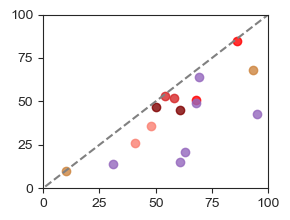

In [27]:
# N vs R for HIV

plt.figure(figsize=(3,2.3))

for ip,pid in enumerate(PWH_ppts):

    cz=outdf['color'][outdf['pid']==pid+'_t0'].iloc[0] #get the color for this ppt
    tdf=df1[df1['pid']==int(pid[3:])]
    
    for it,tt in enumerate(tdf['monthsART'].unique()):
        tdf2 = tdf[tdf['monthsART']==tt]
        a=-np.sort(-tdf2['counts'])
        a=a[a>0]
        plt.scatter(sum(a),len(a),color=cz,label=str(pid)+str(it+1),alpha=0.8)
        
#DELSPC
DELl=[]
for p in df2.columns[1:]:
    
    a=df2[p].dropna()
    a=-np.sort(-a)
    plt.scatter(sum(a),len(a),color=DELcolor,label=p,alpha=0.8)
    
    DELl.append(['DEL'+p[1:],sum(a),len(a)])
    
plt.xlim([0.8,1e2])
plt.ylim([0.8,1e2])
#plt.xlabel('HIV clone sample size')
#plt.ylabel('HIV clone richness')
plt.xticks(range(0,101,25))
plt.yticks(range(0,101,25))
plt.plot([1,1e6],[1,1e6],ls='--',color='gray')

plt.tight_layout()
plt.savefig('figures/samplesizerichness_HIV.svg',dpi=600)


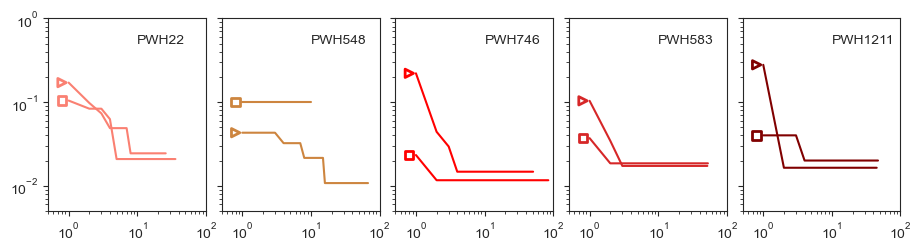

In [33]:
#show all longitudinal provirus

mz=['o','s','>']
fig,axarr=plt.subplots(1,5,sharex=True,sharey=True,figsize=(11,2.5))
for ip,pid in enumerate(PWH_ppts2):

    cz=outdf['color'][outdf['pid']=='PWH'+pid+'_t0'].iloc[0] #get the color for this ppt
    ax=axarr[ip]

    tdf=df1[df1['pid']==int(pid)]
    
    for it,tt in enumerate(tdf['monthsART'].unique()):
        tdf2 = tdf[tdf['monthsART']==tt]
        
        a=-np.sort(-tdf2['counts'])
        a=a[a>0]
        
        ax.loglog(np.arange(len(a))+1,a/np.sum(a),color=cz,label=str(p)+str(it+1))#,marker='.')
        ax.scatter(0.8,a[0]/sum(a),marker=mz[it+1],facecolors='none', edgecolors=cz,lw=2)#lw=tp+1)
    ax.annotate(PWH_ppts[ip],[10,5e-1],fontsize=10)
    #ax.set_title(pid)

ax.set_xticks(np.logspace(0,3,4))
ax.set_yticks(np.logspace(-5,0,6))
ax.set_ylim([5e-3,1])     
ax.set_xlim([0.5,1e2])     

fig.subplots_adjust(hspace = 0.1, wspace=0.1)
fig.savefig('figures/SADS-provirus-longitudinal.svg',dpi=600)

